<a href="https://colab.research.google.com/github/hss0727/BigData_project_Spark/blob/main/TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing using Spark ML package



---

ML package operates on Spark DataFrames. There are three main classes in the ML package:
<ol>
<li>Transformer: transforms data and add a new column to the DataFrame</li>
<li>Estimator: models to make predictions or classify the observations</li>
<li>Pipeline: end-to-end transformation-estimation process that ingests some raw data (DataFrame) and estimages a statistical model</li>
</ol>


---



In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install findspark
!pip install pyspark
!pip install sparknlp
!pip install nltk


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 42 kB/s 
     |████████████████████████████████| 199 kB 40.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=7cf9507413089644be9ad510638f191ac79d0310ecd4ad39fbb7ca8fc88028ad
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 648 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Start Spark Session with Spark NLP
spark = sparknlp.start()


<br>
<br>
<br>
<br>
<br>
<br>

## **1. Topic Modeling on Submissions data**

---



In [6]:
submissions_en = spark.read.parquet("/content/drive/Shareddrives/502_project/data/submissions_en_cleaned")

In [7]:
submissions_en.show(3)

+------------------+------------------+--------+-----------------+--------------+----------------------+-----------------+---------+----------+------------+-------------------+----------------+---------------------+----------------+-------------+----------------+---------------+------+----------+---------+------+------+----------+--------+------+---------+----------------+----------------------+-------+--------+--------------------+--------------------+------+-----+--------------------+-------------+------------+--------------+-------------+-------+-----------------------+--------------------+------+---------+-------+--------+-----------+---------------------+------------+------------+-----+------------+--------------------+---------+-------+--------+-----------------+------------+--------------+--------------------+--------------------+----------------------+--------------------+----------------+---------------+--------------------+--------------------+----------------+------------+--

In [8]:
text = submissions_en.select('cleaned_text')

<br>
<br>
<br>
<br>
<br>
<br>

#### **1.1 Setup Topic Modeling Pipeline**
---

In [9]:
# Transform data to annotation format using DocumentAssembler
from sparknlp.base import DocumentAssembler
documentAssembler = DocumentAssembler() \
  .setInputCol('cleaned_text')  \
  .setOutputCol('document')

In [10]:
# Setup Tokenizer
from sparknlp.annotator import Tokenizer
tokenizer = Tokenizer() \
  .setInputCols(['document']) \
  .setOutputCol('tokenized')

In [11]:
# Setup Normalization
from sparknlp.annotator import Normalizer
normalizer = Normalizer() \
  .setInputCols(['tokenized'])  \
  .setOutputCol('normalized') \
  .setLowercase(True)

In [12]:
# Setup Lemmatizer
from sparknlp.annotator import LemmatizerModel
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [13]:
# Setup stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Setup stop words cleaner
from sparknlp.annotator import StopWordsCleaner
stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('no_stop_lemmatized') \
     .setStopWords(eng_stopwords)

In [15]:
# Transformation from the annotation format of SparkNLP to a human-readable format
from sparknlp.base import Finisher
finisher = Finisher() \
     .setInputCols(['no_stop_lemmatized']) \
     .setIncludeMetadata(True)

In [16]:
# Define pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline() \
     .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner,
                 finisher])

<br>
<br>
<br>
<br>
<br>
<br>

#### **1.2 Apply Topic Modeling Pipeline to 'Submissions' data**


---



In [17]:
processed_text = pipeline.fit(text).transform(text)

In [18]:
processed_text.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                                                      |finished_no_stop_lemmatized                                                                                                                                  |finished_no_stop_lemmatized_metadata                                                                 

In [19]:
from pyspark.ml.feature import CountVectorizer
tfizer = CountVectorizer(inputCol='finished_no_stop_lemmatized',
                         outputCol='tf_features')
tf_model = tfizer.fit(processed_text)
tf_result = tf_model.transform(processed_text)

In [20]:
from pyspark.ml.feature import IDF
idfizer = IDF(inputCol='tf_features', 
              outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)

In [21]:
from pyspark.ml.clustering import LDA
num_topics = 10
max_iter = 10
lda = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

In [22]:
import pyspark.sql.types as T

vocab = tf_model.vocabulary

def get_words(token_list):
    return [vocab[token_id] for token_id in token_list]

udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))

In [23]:
num_top_words = 10

topics = lda_model  \
     .describeTopics(num_top_words) \
     .withColumn('topicWords', udf_to_words(F.col('termIndices')))

topics.select('topic', 'topicWords').show(truncate=100)

+-----+----------------------------------------------------------------------------------------+
|topic|                                                                              topicWords|
+-----+----------------------------------------------------------------------------------------+
|    0|[russian, ukrainian, ukraine, mariupol, azov, azovstal, commander, war, video, military]|
|    1|      [war, russia, ukraine, putin, country, world, people, russian, support, ukrainian]|
|    2|            [ukraine, russia, russian, refugee, oil, germany, ukrainian, gas, aid, kyiv]|
|    3|    [moskva, russian, sink, column, ukrainian, ka, warship, belarusian, russia, ukraine]|
|    4|     [russian, ukrainian, ukraine, force, call, donetsk, street, russia, region, people]|
|    5|   [russian, ukrainian, tank, destroy, shoot, vehicle, ukraine, soldier, capture, force]|
|    6|   [island, russian, ukraine, snake, explosion, report, russia, bayraktar, news, remove]|
|    7|[force, ukraine, russia

In [24]:
topics.show(truncate=50)

+-----+-------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|topic|                                termIndices|                                       termWeights|                                        topicWords|
+-----+-------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|    0|     [0, 2, 1, 23, 215, 357, 278, 4, 11, 9]|[0.005709059745626543, 0.005301373300482019, 0....|[russian, ukrainian, ukraine, mariupol, azov, a...|
|    1|          [4, 3, 1, 5, 18, 20, 7, 0, 19, 2]|[0.008949821000815665, 0.008219826278652163, 0....|[war, russia, ukraine, putin, country, world, p...|
|    2|    [1, 3, 0, 81, 187, 87, 2, 174, 129, 10]|[0.006497638444603341, 0.0056682578983063454, 0...|[ukraine, russia, russian, refugee, oil, german...|
|    3|[619, 0, 703, 468, 2, 1318, 595, 548, 3, 1]|[0.0055702575532582755, 0

<br>
<br>
<br>
<br>
<br>
<br>

#### **1.3 Model Tuning - Refilter Stopwords**
---

In [45]:
# Add stopwords
new_stop_words = ['russia','russian','ukraine','ukrainian','delete', 'http', 'https', 'amp', 'rt', 'rp']
eng_stopwords_v2 = eng_stopwords + new_stop_words

In [46]:
# Setup NEW stop words cleaner
from sparknlp.annotator import StopWordsCleaner
stopwords_cleaner_v2 = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('no_stop_lemmatized') \
     .setStopWords(eng_stopwords_v2)

In [47]:
# Define NEW pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline() \
     .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 stopwords_cleaner_v2,
                 finisher,
                 tfizer,
                 idfizer])

In [48]:
processed_text_v2 = pipeline.fit(text).transform(text)

In [49]:
# Define NEW LDA model
num_topics = 15
max_iter = 10
num_top_words = 10

lda_v2 = LDA(k=num_topics, 
          maxIter=max_iter, 
          featuresCol='tf_idf_features')
lda_model_v2 = lda_v2.fit(processed_text_v2)

topics_v2 = lda_model_v2  \
     .describeTopics(num_top_words) \
     .withColumn('topicWords', udf_to_words(F.col('termIndices')))

topics_v2.select('topic', 'termWeights', 'topicWords').show(truncate=100)

+-----+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|topic|                                                                                         termWeights|                                                                                   topicWords|
+-----+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
|    0|[0.008975979205910175, 0.005557241368696533, 0.005451925767971982, 0.004859297651399427, 0.004142...|                   [place, push, discuss, airport, bit, record, term, assistance, rally, war]|
|    1|[0.008909714252280978, 0.006852496832615221, 0.006639220920359529, 0.006166176732697866, 0.006079...|                 [kill, ukrainian, soldier, shoot, defense, nato, capture, stop,

In [50]:
test = topics_v2.toPandas()

In [51]:
test['zipped'] =  test.apply(lambda row: list(zip(row[3], row[2])), axis=1)
test.drop(['termIndices','termWeights','topicWords'], axis=1, inplace=True)

In [52]:
type(test)

pandas.core.frame.DataFrame

In [53]:
test.head()

,topic,zipped
0,0,"[(place, 0.008975979205910175), (push, 0.00555..."
1,1,"[(kill, 0.008909714252280978), (ukrainian, 0.0..."
2,2,"[(russia, 0.006108344746950382), (ukraine, 0.0..."
3,3,"[(speak, 0.0047283330751832905), (prosecutor, ..."
4,4,"[(russian, 0.00844458467353643), (ukraine, 0.0..."


In [54]:
test['zipped']

0     [(place, 0.008975979205910175), (push, 0.00555...
1     [(kill, 0.008909714252280978), (ukrainian, 0.0...
2     [(russia, 0.006108344746950382), (ukraine, 0.0...
3     [(speak, 0.0047283330751832905), (prosecutor, ...
4     [(russian, 0.00844458467353643), (ukraine, 0.0...
5     [(equipment, 0.005345558722541726), (war, 0.00...
6     [(czech, 0.004074573133810485), (throw, 0.0039...
7     [(council, 0.006020052298709502), (canadian, 0...
8     [(zone, 0.005068398683508662), (american, 0.00...
9     [(video, 0.007636010784562145), (long, 0.00665...
10    [(run, 0.008593735395061529), (truth, 0.006414...
11    [(shelter, 0.008354115493930595), (demand, 0.0...
12    [(st, 0.004470894729211706), (journalist, 0.00...
13    [(cut, 0.007761828979625665), (talk, 0.0057473...
14    [(support, 0.0061448055421767615), (mariupol, ...
Name: zipped, dtype: object

In [55]:
words, probs = [], []
for topic in range(len(test['zipped'])):
  words.append([t[0] for t in test['zipped'][topic]])
  probs.append([t[1] for t in test['zipped'][topic]])

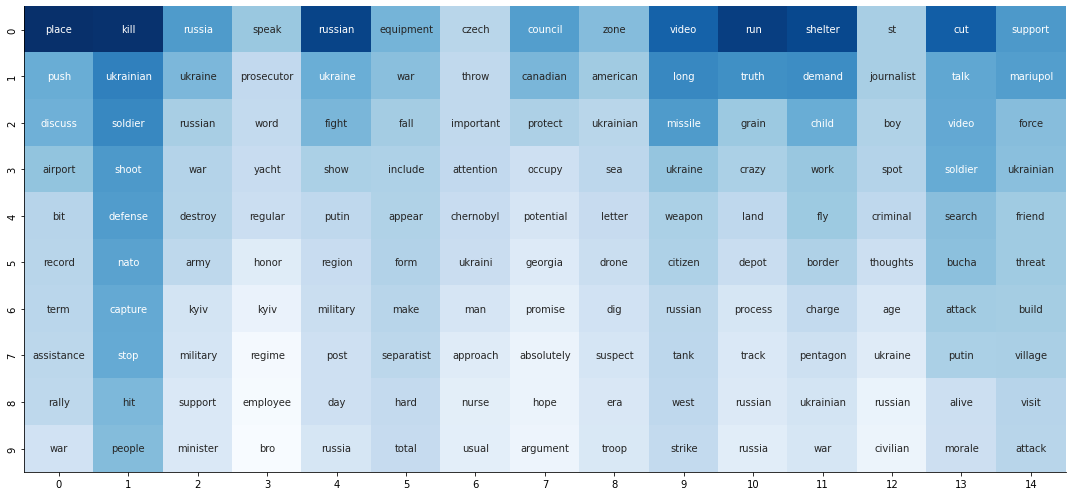

In [56]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(pd.DataFrame(probs).T,
            annot = pd.DataFrame(words).T,
            fmt='',
            ax=ax,
            cmap='Blues',
            cbar=False)
sns.despine()
fig.tight_layout()

In [40]:
test2 = test.explode('zipped')

In [41]:
test2['word'], test2['prob'] = test2.zipped.str

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [42]:
test2

,topic,zipped,word,prob
0,0,"(place, 0.013392915260716749)",place,0.013393
0,0,"(girl, 0.008214361733390034)",girl,0.008214
0,0,"(young, 0.005860562013874368)",young,0.005861
0,0,"(push, 0.004820490536064717)",push,0.004820
0,0,"(war, 0.00421997869564908)",war,0.004220
...,...,...,...,...
14,14,"(run, 0.0036935563927242634)",run,0.003694
14,14,"(missile, 0.0035176814933305504)",missile,0.003518
14,14,"(world, 0.003428375057460459)",world,0.003428
14,14,"(happen, 0.0033393012203885354)",happen,0.003339


In [43]:
processed_text_v2.show(5)

+--------------------+---------------------------+------------------------------------+--------------------+--------------------+
|        cleaned_text|finished_no_stop_lemmatized|finished_no_stop_lemmatized_metadata|         tf_features|     tf_idf_features|
+--------------------+---------------------------+------------------------------------+--------------------+--------------------+
|screenshots kyiv ...|       [screenshot, kyiv...|                [{sentence, 0}, {...|(59326,[6,296,348...|(59326,[6,296,348...|
|irkutsk peace pro...|       [irkutsk, peace, ...|                [{sentence, 0}, {...|(59326,[174,345,3...|(59326,[174,345,3...|
|conservative hold...|       [conservative, ho...|                [{sentence, 0}, {...|(59326,[36,145,48...|(59326,[36,145,48...|
|           energodar|                [energodar]|                     [{sentence, 0}]|(59326,[2558],[1.0])|(59326,[2558],[7....|
|advice russian pr...|         [advice, prisoner]|                [{sentence, 0}, {...|(59

In [57]:
tf_result.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                                                      |finished_no_stop_lemmatized                                                                                       

<br>
<br>
<br>
<br>
<br>
<br>

#### **1.4 Testing UDF to Tag the Documents**
---

In [95]:
test_tag = tf_result.select('finished_no_stop_lemmatized')

In [97]:
test_tag.show(3, truncate=False)

+-------------------------------------------------+
|finished_no_stop_lemmatized                      |
+-------------------------------------------------+
|[screenshot, kyiv, resident]                     |
|[irkutsk, peace, protester, russia, lead, police]|
|[conservative, hold, purim, water, call]         |
+-------------------------------------------------+
only showing top 3 rows



In [77]:
def find_tag(list_of_words, topic):
  count = 0
  for i in range(len(list_of_words)):
    if list_of_words[i] in topic:
      #print(list_of_words[i])
      count += 1
  return count/len(topic)

In [74]:
a = ['a','d','c']
t = ['a','d','e']

In [75]:
find_tag(a,t)

a
d


0.6666666666666666

In [82]:
test_topics = topics.toPandas()
test_topics.drop(['termIndices','termWeights'], axis=1, inplace=True)
test_topics.head()

,topic,topicWords
0,0,"[russian, ukrainian, ukraine, mariupol, azov, ..."
1,1,"[war, russia, ukraine, putin, country, world, ..."
2,2,"[ukraine, russia, russian, refugee, oil, germa..."
3,3,"[moskva, russian, sink, column, ukrainian, ka,..."
4,4,"[russian, ukrainian, ukraine, force, call, don..."


In [83]:
test_topics['topicWords'].iloc[0,]

['russian',
 'ukrainian',
 'ukraine',
 'mariupol',
 'azov',
 'azovstal',
 'commander',
 'war',
 'video',
 'military']

In [84]:
test_topics1 = test_topics['topicWords'].iloc[0,]

In [111]:
test_tag = test_tag.withColumn('topic2', find_tag_udf(F.col('finished_no_stop_lemmatized')))

In [112]:
test_tag.show(5, truncate=False)

+-------------------------------------------------+------+
|finished_no_stop_lemmatized                      |topic2|
+-------------------------------------------------+------+
|[screenshot, kyiv, resident]                     |0.0   |
|[irkutsk, peace, protester, russia, lead, police]|0.0   |
|[conservative, hold, purim, water, call]         |0.0   |
|[energodar]                                      |0.0   |
|[advice, russian, prisoner]                      |0.1   |
+-------------------------------------------------+------+
only showing top 5 rows



In [110]:
find_tag_udf = F.udf(lambda z: find_tag(z,test_topics1))

<br>
<br>
<br>
<br>
<br>
<br>

#### **1.5 Document Tagging**
---

In [128]:
topics_df = topics_v2.toPandas()
topics_df.drop(['termIndices','termWeights'], axis=1, inplace=True)

In [129]:
topics_df

,topic,topicWords
0,0,"[place, push, discuss, airport, bit, record, t..."
1,1,"[kill, ukrainian, soldier, shoot, defense, nat..."
2,2,"[russia, ukraine, russian, war, destroy, army,..."
3,3,"[speak, prosecutor, word, yacht, regular, hono..."
4,4,"[russian, ukraine, fight, show, putin, region,..."
5,5,"[equipment, war, fall, include, appear, form, ..."
6,6,"[czech, throw, important, attention, chernobyl..."
7,7,"[council, canadian, protect, occupy, potential..."
8,8,"[zone, american, ukrainian, sea, letter, drone..."
9,9,"[video, long, missile, ukraine, weapon, citize..."


In [130]:
topics_list = topics_df.topicWords.tolist()

In [131]:
topics_list[0]

['place',
 'push',
 'discuss',
 'airport',
 'bit',
 'record',
 'term',
 'assistance',
 'rally',
 'war']

In [134]:
udf_list = []
for i in range(len(topics_list)):
  udf_list.append(F.udf(lambda z: find_tag(z,topics_list[i])))

In [135]:
udf_list

[<function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>,
 <function __main__.<lambda>(z)>]

In [133]:
doc_tagged = tf_result.select('finished_no_stop_lemmatized')

In [136]:
doc_tagged = doc_tagged \
  .withColumn('topic1_weight', udf_list[0](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic2_weight', udf_list[1](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic3_weight', udf_list[2](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic4_weight', udf_list[3](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic5_weight', udf_list[4](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic6_weight', udf_list[5](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic7_weight', udf_list[6](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic8_weight', udf_list[7](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic9_weight', udf_list[8](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic10_weight', udf_list[9](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic11_weight', udf_list[10](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic12_weight', udf_list[11](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic13_weight', udf_list[12](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic14_weight', udf_list[13](F.col('finished_no_stop_lemmatized'))) \
  .withColumn('topic15_weight', udf_list[14](F.col('finished_no_stop_lemmatized'))) \

In [138]:
doc_tagged.show(30)

+---------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+
|finished_no_stop_lemmatized|topic1_weight|topic2_weight|topic3_weight|topic4_weight|topic5_weight|topic6_weight|topic7_weight|topic8_weight|topic9_weight|topic10_weight|topic11_weight|topic12_weight|topic13_weight|topic14_weight|topic15_weight|
+---------------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+
|       [screenshot, kyiv...|          0.0|          0.0|          0.0|          0.0|          0.0|          0.0|          0.0|          0.0|          0.0|           0.0|           0.0|           0.0|           0.0|           0.0|           0.0|
|       [irkutsk

<br>
<br>
<br>
<br>
<br>
<br>

#### **1.6 Document Tagging ver 2**
---

In [ ]:
documents = spark.createDataFrame([
    [123myNumericId, Vectors.sparse(len(words_in_our_corpus), {index_of_word:count}],
    [2, Vectors.sparse(len(words_in_our_corpus), {index_of_word:count, another:1.0}],
], schema=["id", "features"]
transformed = ldaModel.transform(documents)
dist = transformed.take(1)

<br>
<br>
<br>
<br>
<br>
<br>

## **2. Topic Modeling on Comments data**
---

In [ ]:
comments_en = spark.read.parquet("/content/drive/Shareddrives/502_project/data/comments_en_cleaned")

In [ ]:
comments_en.show(3)

+-----------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------------+------+-------+------------+---------+----------+--------------------+------------+-----+--------+-------------+------------+------------+-------------+-------------+----------+--------------------+--------------------+
|     author|author_cakeday|author_flair_css_class|author_flair_text|                text|can_gild|controversiality|        created_utc|distinguished|      edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|retrieved_on|score|stickied|    subreddit|subreddit_id|created_date|      Russian|    Ukrainian|   English|  normalizedDocument|        cleaned_text|
+-----------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------------+------+-------+------------+---------+----------+--------------------+-

<br>
<br>
<br>
<br>
<br>
<br>

#### **2.1 Apply Topic Modeling Pipeline to both 'Submissions' and 'Comments' data**

In [ ]:
df_sub = submissions_en.select('cleaned_text')
df_com = comments_en.select('cleaned_text')

In [ ]:
df_sub.show(1)

+--------------------+
|        cleaned_text|
+--------------------+
|screenshots kyiv ...|
+--------------------+
only showing top 1 row



In [ ]:
df_com.show(1)

+--------------------+
|        cleaned_text|
+--------------------+
|think annex terri...|
+--------------------+
only showing top 1 row



In [ ]:
(df_sub.count(), df_com.count(), df_sub.count() + df_com.count())

(263623, 6762807, 7026430)

Stack dataframes by ROWS using `.union` method

In [ ]:
df_stacked = df_sub.union(df_com)

In [ ]:
df_stacked.count()

7026430

In [ ]:
processed_combined = pipeline.fit(df_stacked).transform(df_stacked)

In [ ]:
tf_model_combined = tfizer.fit(processed_combined)
tf_result_combined = tf_model_combined.transform(processed_combined)

In [ ]:
idf_model_combined = idfizer.fit(tf_result_combined)
tfidf_result_combined = idf_model_combined.transform(tf_result_combined)

In [ ]:
lda_model_combined = lda.fit(tfidf_result_combined)

In [ ]:
topics_combined = lda_model_combined  \
     .describeTopics(num_top_words) \
     .withColumn('topicWords', udf_to_words(F.col('termIndices')))

topics_combined.select('topic', 'topicWords').show(truncate=100)

In [ ]:
topics_df = topics_combined.toPandas()

In [ ]:
topics_df['zipped'] =  topics_df.apply(lambda row: list(zip(row[3], row[2])), axis=1)
topics_df.drop(['termIndices','termWeights','topicWords'], axis=1, inplace=True)

In [ ]:
words_combined, probs_combined = [], []
for topic in range(len(topics_df['zipped'])):
  words_combined.append([t[0] for t in topics_df['zipped'][topic]])
  probs_combined.append([t[1] for t in topics_df['zipped'][topic]])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(pd.DataFrame(probs_combined).T,
            annot = pd.DataFrame(words_combined).T,
            fmt='',
            ax=ax,
            cmap='Blues',
            cbar=False)
sns.despine()
fig.tight_layout()

Reference: <br>
https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.LDA.html#pyspark.ml.clustering.LDA.fitMultiple <br><br>

https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e 
<br><br>

https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3741049972324885/3783546674231782/4413065072037724/latest.html
<br><br>